In [ ]:
import sys
import numpy as np
import cv2
import cv2.ml
from time import sleep
import pytz
from datetime import datetime
from pysolar import solar
import os
import numpy as np
from random import shuffle
from matplotlib import pyplot as plt
import matplotlib as mpl
import pandas as pd
from pandas import read_csv, read_excel, DataFrame
from skimage.feature import hessian_matrix_det as Hessian
from skimage.feature import local_binary_pattern as LBP
import pickle
import logging
logging.basicConfig(level=logging.INFO)

p0 = os.path.join('../../','raw','CookIRCamET','Images','CookHY2023')
p00 = os.path.join('../../','raw','CookIRCamET','Images','CprlHY2023')
p3 = os.path.join('../../','work','CookIRCamET','Working')
n_components1 = 2
n_components2 = 4
n_components3 = 8


# In[2]:

cmap3 = mpl.colors.ListedColormap(['y', 'r', 'g','w','b','m','c','k'])
norm3 = mpl.colors.BoundaryNorm([0,1,2,3,4,5,6,7,8], cmap3.N)

In [ ]:
model_mlp3_v1 = pickle.load(open(os.path.join(p3,'finalized_model3_mlp.pk.sav'), 'rb'))
scaler_v1 = pickle.load(open(os.path.join(p3,'scaler_mlp.pk.sav'), 'rb'))
model_mlp3_v2 = pickle.load(open(os.path.join(p3,'finalized_model3_mlp_v2.pk.sav'), 'rb'))
scaler_v2 = pickle.load(open(os.path.join(p3,'scaler_mlp_v2.pk.sav'), 'rb'))

cal_nsar_v0 = pickle.load(open(os.path.join(p3,'calibration_nsar1.pk.sav'), 'rb'))#20220705
cal_nsar_v1 = pickle.load(open(os.path.join(p3,'calibration_nsar2.pk.sav'), 'rb'))#20221122
cal_nsar_v2 = pickle.load(open(os.path.join(p3,'calibration_nsar3.pk.sav'), 'rb'))#20230315
cal_cprl = pickle.load(open(os.path.join(p3,'calibration_cprl1.pk.sav'), 'rb'))#20230305

In [ ]:
def localSD(mat, n):    
    mat=np.float32(mat)
    mu = cv2.blur(mat,(n,n))
    mdiff=mu-mat
    mat2=cv2.blur(np.float64(mdiff*mdiff),(n,n))
    sd = np.float32(cv2.sqrt(mat2))
    
    return sd

In [ ]:
def quadrant(img_size,coord):
    if coord[0]>img_size[1]/2 and coord[1]>img_size[0]/2:
        return 1
    elif coord[0]>img_size[1]/2 and coord[1]<=img_size[0]/2:
        return 4
    elif coord[0]<=img_size[1]/2 and coord[1]>img_size[0]/2:
        return 2
    else:
        return 3

In [ ]:
def register_ir(ir,v,bgr,warp_mat=None):
    
    dilate_v=True
    dilate_ir=False
    erode_v=True
    erode_ir=False
    hough_thresh_ir=36
    if v.shape[1]==1280:
        hough_thresh_v=240    
    elif v.shape[1]==1920:
        hough_thresh_v=360
    if warp_mat is None:
        print('Calculate affine')
        srcXY, dstXY = [], []
        cv2.normalize(ir, ir, 0, 65535, cv2.NORM_MINMAX)
        cv2.normalize(v, v, 0, 255, cv2.NORM_MINMAX)

        ir=np.uint8(np.right_shift(ir, 8, ir))

        # Otsu's thresholding
        xwin = int(v.shape[1]/(1280/240))+1
        C=-50
        if v.shape[1]==1920: C=-87
        # print(xwin,C)
        # print(v.shape)
        v = cv2.adaptiveThreshold(v,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,xwin,C)
        #_,v = cv2.threshold(v,245,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        ir = cv2.adaptiveThreshold(ir,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY_INV,41,50)
        #_,ir = cv2.threshold(ir,137,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
        erodewin = int(1920/(1280/2))+1
        if erode_v:
            kernel = np.ones((erodewin,erodewin),np.uint8)
            v = cv2.erode(v,kernel,iterations = 1)

        if erode_ir:    
            kernel = np.ones((erodewin,erodewin),np.uint8)
            ir = cv2.erode(ir,kernel,iterations = 1)

        if dilate_v:
            kernel = np.ones((erodewin,erodewin),np.uint8)
            v = cv2.dilate(v,kernel,iterations = 1)

        if dilate_ir:
            kernel = np.ones((erodewin,erodewin),np.uint8)
            ir = cv2.dilate(ir,kernel,iterations = 1)
        
        # plt.imshow(v)
        # plt.title('v')
        # plt.show()     
        # plt.imshow(ir)
        # plt.title('ir')
        # plt.show()     

        line_params_v={'slope':[],'intercept':[]}
        lines_v = cv2.HoughLines(v,1,np.pi/180,hough_thresh_v)
        slope = np.zeros(lines_v.shape[0])
        intercept = np.zeros(lines_v.shape[0])
        four_v = np.zeros((lines_v.shape[0],4))
        ii = 0
        for line in lines_v:
            rho,theta = line[0]
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a*rho
            y0 = b*rho
            x1 = int(x0 + v.shape[1]*(-b))
            y1 = int(y0 + v.shape[1]*(a))
            x2 = int(x0 - v.shape[1]*(-b))
            y2 = int(y0 - v.shape[1]*(a))
            cv2.line(bgr,(x1,y1),(x2,y2),(0,0,255),2)
            four_v[ii,:]=np.array([x1,y1,x2,y2])
            if x2==x1:
                slope[ii]=(y2-y1)/(x2-x1+.0000001*np.random.randn(1))
            else:
                slope[ii]=(y2-y1)/(x2-x1)
            intercept[ii]=(y2-slope[ii]*x2)
            ii = ii+1

        line_params_v['slope']=slope
        line_params_v['intercept']=intercept

        lines_ir = cv2.HoughLines(ir,1,np.pi/180,hough_thresh_ir)
        line_params_ir={'slope':[],'intercept':[]}
        slope = np.zeros(lines_ir.shape[0])
        intercept = np.zeros(lines_ir.shape[0])
        four_ir = np.zeros((lines_ir.shape[0],4))
        ii = 0
        for line in lines_ir:
            rho,theta = line[0]
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a*rho
            y0 = b*rho
            x1 = int(x0 + 200*(-b))
            y1 = int(y0 + 200*(a))
            x2 = int(x0 - 200*(-b))
            y2 = int(y0 - 200*(a))
            cv2.line(bgr,(x1,y1),(x2,y2),(255,0,0),2)
            four_ir[ii,:]=np.array([x1,y1,x2,y2])
            if x2==x1:
                slope[ii]=(y2-y1)/(x2-x1+.0000001*np.random.randn(1))
            else:
                slope[ii]=(y2-y1)/(x2-x1)
            intercept[ii]=(y2-slope[ii]*x2)
            ii = ii+1
        line_params_ir['slope']=slope
        line_params_ir['intercept']=intercept

        n = line_params_v['slope'].shape[0]
        combos = int((n*(n-1))/2)
        corner_v = np.zeros((combos,2))
        kk = 0
        for ii in range(line_params_v['slope'].shape[0]):
            for jj in range(ii,line_params_v['slope'].shape[0]):
                if ii!=jj:
                    if np.abs(np.abs(line_params_v['slope'][ii])*np.abs(line_params_v['slope'][jj])-1)<.1:
                        x = (line_params_v['intercept'][jj]-line_params_v['intercept'][ii])/(line_params_v['slope'][ii]-line_params_v['slope'][jj])
                        y = line_params_v['slope'][ii]*x+line_params_v['intercept'][ii]
                        corner_v[kk,0] = x
                        corner_v[kk,1] = y
                        kk = kk+1
                        try:
                            cv2.circle(bgr, (int(x),int(y)), radius=3, color=(0, 0, 0), thickness=-1)
                        except:
                            pass
                    else:
                        x = np.nan
                        y = np.nan
                        corner_v[kk,0] = x
                        corner_v[kk,1] = y
                        kk = kk+1
        n = line_params_ir['slope'].shape[0]
        combos = int((n*(n-1))/2)
        corner_ir = np.zeros((combos,2))
        kk = 0
        for ii in range(line_params_ir['slope'].shape[0]):
            for jj in range(ii,line_params_ir['slope'].shape[0]):
                if ii!=jj:
                    if np.abs(np.abs(line_params_ir['slope'][ii])*np.abs(line_params_ir['slope'][jj])-1)<.1:
                        x = (line_params_ir['intercept'][jj]-line_params_ir['intercept'][ii])/(line_params_ir['slope'][ii]-line_params_ir['slope'][jj])
                        y = line_params_ir['slope'][ii]*x+line_params_ir['intercept'][ii]
                        corner_ir[kk,0] = x
                        corner_ir[kk,1] = y
                        kk = kk+1
                        try:
                            cv2.circle(bgr, (int(x),int(y)), radius=3, color=(255, 255, 255), thickness=-1)
                        except:
                            pass
                    else:
                        x = np.nan
                        y = np.nan
                        corner_ir[kk,0] = x
                        corner_ir[kk,1] = y
                        kk = kk+1

        corner_ir = corner_ir[np.argwhere(np.isnan(corner_ir[:,0])==False)[:,0],]
        corner_v = corner_v[np.argwhere(np.isnan(corner_v[:,0])==False)[:,0],]

       
        # plt.imshow(bgr)
        # plt.show()     
        # plt.imshow(ir)
        # plt.show()     

        q_v = np.zeros(corner_v.shape[0])
        q_ir = np.zeros(corner_ir.shape[0])
        for ii in range(corner_v.shape[0]):
            q_v[ii] = quadrant(bgr.shape[0:2],corner_v[ii,:])    
        for jj in range(corner_ir.shape[0]):
            q_ir[jj] = quadrant(ir.shape[0:2],corner_ir[jj,:])

        q_list=list()
        for ii in range(corner_v.shape[0]):
            for jj in range(corner_ir.shape[0]):
                if q_v[ii]==q_ir[jj]:
                    srcXY.append(corner_ir[jj,:])
                    dstXY.append(corner_v[ii,:])
                    q_list.append(q_v[ii])
                    
        srcXY = np.float32(np.array(srcXY))
        dstXY = np.float32(np.array(dstXY))
        q_list = np.float32(np.array(q_list))
        
        src = np.zeros((4,2))
        dst = np.zeros((4,2))
        
        for i in range(4):
            src[i,:] = np.mean(srcXY[q_list==i+1,:],axis=0)
            dst[i,:] = np.mean(dstXY[q_list==i+1,:],axis=0)
        warp_mat = cv2.estimateAffine2D(src,dst)
        warp_dst = None
    else:
        print('Apply affine')
        warp_dst = cv2.warpAffine(ir, warp_mat[0], (v.shape[1], v.shape[0]),flags=cv2.INTER_NEAREST)   
    return warp_mat, warp_dst

In [45]:
imgs=[]
f_sol_sun = []
f_sol_shd = []
f_res_sun = []
f_res_shd = []
f_veg_sun = []
f_veg_shd = []
f_snw_sun = []
f_snw_shd = []

T_sol_sun = []
T_sol_shd = []
T_res_sun = []
T_res_shd = []
T_veg_sun = []
T_veg_shd = []
T_snw_sun = []
T_snw_shd = []

elevation = []
azimuth = []

times = []

n_img=0

start_dates_cook = ['20221028224215',
               '20221108180152',
               '20221125231429',
               '20221229191212',
               '20230301223610',
               '20230320171323',
               '20230522171148',
               '20230525222154',
               '20230601192831',
               '20230602184516']

stop_dates_cook =  ['20221104234238',
               '20221116210712',
               '20221229174156',
               '20230221015754',
               '20230301223630',
               '20230322045000',
               '20230525111517',
               '20230601022210',
               '20230602033124']
start_dates_cprl = ['20230411192131',
                    '20230427001305',
                    '20230607014817']
stop_dates_cprl =  ['20230426231253',
                    '20230531114644']

start_dates_cook = [pytz.utc.localize(datetime.strptime(d, '%Y%m%d%H%M%S')) for d in start_dates_cook]
stop_dates_cook = [pytz.utc.localize(datetime.strptime(d, '%Y%m%d%H%M%S')) for d in stop_dates_cook]

start_dates_cprl = [pytz.utc.localize(datetime.strptime(d, '%Y%m%d%H%M%S')) for d in start_dates_cprl]
stop_dates_cprl = [pytz.utc.localize(datetime.strptime(d, '%Y%m%d%H%M%S')) for d in stop_dates_cprl]


lat = np.nan
lon = np.nan
ti = 0
ti_change = True
# warp_mat = (np.array([[ 11.08898243,  -0.42063226, 126.98795655],
#         [ -0.14639544,  11.22961801,  58.99876632]]),
#  np.array([[1],
#         [1],
#         [0],
#         [1]], dtype=np.uint8))
for di, start_dates, stop_dates, cal_list in zip([p0],[start_dates_cook], [stop_dates_cook],[[cal_nsar_v2]]):
    for version, model, scaler, cal in zip(['V2'],[model_mlp3_v2],[scaler_v2],cal_list):
        f_imgs_ir = list()
        f_imgs_bgr = list()
        utc_ir = list()
        utc_bgr = list()
        for f in os.listdir(os.path.join(di,version)):
            if '.png' in f:

                time_place = f.split('.png')[0].split('_')
                if version=='V1': 
                    t_meas = pytz.utc.localize(datetime.strptime(time_place[0],'%Y%m%d%H%M%S'))
                elif version=='V2':
                    if di==p0:
                        t_meas = pytz.utc.localize(datetime.strptime(time_place[0]+time_place[1],'%Y%m%d%H%M%S'))
                    elif di==p00:
                        t_meas = pytz.utc.localize(datetime.strptime(time_place[0],'%Y%m%d%H%M%S'))
                if '_bgr' in f:
                    f_imgs_bgr.append(f)
                    utc_bgr.append(t_meas)
                if '_ir' in f:
                    f_imgs_ir.append(f)
                    utc_ir.append(t_meas)

        ibgr = np.argsort(utc_bgr)
        iir = np.argsort(utc_ir)
        utc_bgr = np.array(utc_bgr)[ibgr]
        utc_ir = np.array(utc_ir)[iir]
        f_imgs_bgr = np.array(f_imgs_bgr)[ibgr]
        f_imgs_ir = np.array(f_imgs_ir)[iir]

        #find closest IR match to BGR
        idx = []
        for utc, f in zip(utc_bgr,f_imgs_bgr):
            idx.append(np.argmin(np.abs(utc_ir-utc)))

        utc_ir = np.array(utc_ir)[idx]
        f_imgs_ir = np.array(f_imgs_ir)[idx]
        for f_bgr, f_ir in zip(f_imgs_bgr,f_imgs_ir):
            print(f_bgr)
            bgr = cv2.imread(os.path.join(di,version,f_bgr),cv2.IMREAD_UNCHANGED)
            #filter nighttime
            #20221017084722_-117.081903_46.781495_bgr.png
            time_place = f_bgr.split('_bgr.')[0].split('_')
            if version=='V1':
                utc = pytz.utc.localize(datetime.strptime(time_place[0], '%Y%m%d%H%M%S'))
            elif version=='V2':
                if di==p0:
                    utc = pytz.utc.localize(datetime.strptime(time_place[0]+time_place[1],'%Y%m%d%H%M%S'))
                elif di==p00:
                    utc = pytz.utc.localize(datetime.strptime(time_place[0], '%Y%m%d%H%M%S'))
            if utc>=start_dates[ti] and utc<=stop_dates[ti]: 
                theta = np.nan
                phi = np.nan
                if version == 'V1':
                    if 'nofix' not in time_place:
                        lat = np.double(time_place[2])
                        lon = np.double(time_place[1])
                    elif 'nofix' in time_place and di==p00:
                        #Latitude: 35 ° 11’ 17.45”; Longitude: 102° 5’ 43.98”; elevation : 1168 m
                        lat = 35+11/60+17.45/3600
                        lon = -(102+5/60+43.98/3600)
                    else:
                        pass
                elif version == 'V2':
                    if di == p0:
                        lat = 46.781553
                        lon = -117.081863
                    elif di == p00:
                        lat = 35+11/60+17.45/3600
                        lon = -(102+5/60+43.98/3600)
                    else:
                        pass
                else:
                    pass
                theta = solar.get_altitude(lat,lon,utc)
                phi = solar.get_azimuth(lat,lon,utc)
                print(utc,phi,theta)

                if theta>10.0:

                    lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
                    hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
                    img = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
                    l,a,bb = cv2.split(lab)
                    h,s,v = cv2.split(hsv)

                    sd_l1 = localSD(l, 127)
                    sd_l2 = localSD(l, 63)
                    sd_l3 = localSD(l, 31)

                    lbp_l1 = LBP(l, 32, 4, method='ror')
                    lbp_l2 = LBP(l, 24, 3, method='ror')
                    lbp_l3 = LBP(l, 16, 2, method='ror')

                    sd_a1 = localSD(a, 127)
                    sd_a2 = localSD(a, 63)
                    sd_a3 = localSD(a, 31)

                    lbp_a1 = LBP(a, 32, 4, method='ror')
                    lbp_a2 = LBP(a, 24, 3, method='ror')
                    lbp_a3 = LBP(a, 16, 2, method='ror')

                    sd_b1 = localSD(bb, 127)
                    sd_b2 = localSD(bb, 63)
                    sd_b3 = localSD(bb, 31)

                    lbp_b1 = LBP(bb, 32, 4, method='ror')
                    lbp_b2 = LBP(bb, 24, 3, method='ror')
                    lbp_b3 = LBP(bb, 16, 2, method='ror')

                    sd_h1 = localSD(h, 127)
                    sd_h2 = localSD(h, 63)
                    sd_h3 = localSD(h, 31)

                    lbp_h1 = LBP(h, 32, 4, method='ror')
                    lbp_h2 = LBP(h, 24, 3, method='ror')
                    lbp_h3 = LBP(h, 16, 2, method='ror')

                    sd_s1 = localSD(s, 127)
                    sd_s2 = localSD(s, 63)
                    sd_s3 = localSD(s, 31)

                    lbp_s1 = LBP(s, 32, 4, method='ror')
                    lbp_s2 = LBP(s, 24, 3, method='ror')
                    lbp_s3 = LBP(s, 16, 2, method='ror')

                    sd_v1 = localSD(v, 127)
                    sd_v2 = localSD(v, 63)
                    sd_v3 = localSD(v, 31)

                    lbp_v1 = LBP(v, 32, 4, method='ror')
                    lbp_v2 = LBP(v, 24, 3, method='ror')
                    lbp_v3 = LBP(v, 16, 2, method='ror')

                    ddepth = cv2.CV_16S

                    lap_l1 = cv2.Laplacian(l,ddepth,ksize=3)
                    lap_l2 = cv2.Laplacian(l,ddepth,ksize=7)
                    lap_l3 = cv2.Laplacian(l,ddepth,ksize=15)

                    lap_a1 = cv2.Laplacian(a,ddepth,ksize=3)
                    lap_a2 = cv2.Laplacian(a,ddepth,ksize=7)
                    lap_a3 = cv2.Laplacian(a,ddepth,ksize=15)

                    lap_b1 = cv2.Laplacian(bb,ddepth,ksize=3)
                    lap_b2 = cv2.Laplacian(bb,ddepth,ksize=7)
                    lap_b3 = cv2.Laplacian(bb,ddepth,ksize=15)

                    lap_h1 = cv2.Laplacian(h,ddepth,ksize=3)
                    lap_h2 = cv2.Laplacian(h,ddepth,ksize=7)
                    lap_h3 = cv2.Laplacian(h,ddepth,ksize=15)

                    lap_s1 = cv2.Laplacian(s,ddepth,ksize=3)
                    lap_s2 = cv2.Laplacian(s,ddepth,ksize=7)
                    lap_s3 = cv2.Laplacian(s,ddepth,ksize=15)

                    lap_v1 = cv2.Laplacian(v,ddepth,ksize=3)
                    lap_v2 = cv2.Laplacian(v,ddepth,ksize=7)
                    lap_v3 = cv2.Laplacian(v,ddepth,ksize=15)

                    img_size = l.shape
                    bb = bb.ravel()
                    a = a.ravel()
                    l = l.ravel()
                    h = h.ravel()
                    s = s.ravel()
                    v = v.ravel()
                    sd_l1 = sd_l1.ravel()
                    sd_l2 = sd_l2.ravel()
                    sd_l3 = sd_l3.ravel()
                    lbp_l1 = lbp_l1.ravel()
                    lbp_l2 = lbp_l2.ravel()
                    lbp_l3 = lbp_l3.ravel()
                    lap_l1 = lap_l1.ravel()
                    lap_l2 = lap_l2.ravel()
                    lap_l3 = lap_l3.ravel()
                    sd_a1 = sd_a1.ravel()
                    sd_a2 = sd_a2.ravel()
                    sd_a3 = sd_a3.ravel()
                    lbp_a1 = lbp_a1.ravel()
                    lbp_a2 = lbp_a2.ravel()
                    lbp_a3 = lbp_a3.ravel()
                    lap_a1 = lap_a1.ravel()
                    lap_a2 = lap_a2.ravel()
                    lap_a3 = lap_a3.ravel()
                    sd_b1 = sd_b1.ravel()
                    sd_b2 = sd_b2.ravel()
                    sd_b3 = sd_b3.ravel()
                    lbp_b1 = lbp_b1.ravel()
                    lbp_b2 = lbp_b2.ravel()
                    lbp_b3 = lbp_b3.ravel()
                    lap_b1 = lap_b1.ravel()
                    lap_b2 = lap_b2.ravel()
                    lap_b3 = lap_b3.ravel()
                    sd_h1 = sd_h1.ravel()
                    sd_h2 = sd_h2.ravel()
                    sd_h3 = sd_h3.ravel()
                    lbp_h1 = lbp_h1.ravel()
                    lbp_h2 = lbp_h2.ravel()
                    lbp_h3 = lbp_h3.ravel()
                    lap_h1 = lap_h1.ravel()
                    lap_h2 = lap_h2.ravel()
                    lap_h3 = lap_h3.ravel()
                    sd_s1 = sd_s1.ravel()
                    sd_s2 = sd_s2.ravel()
                    sd_s3 = sd_s3.ravel()
                    lbp_s1 = lbp_s1.ravel()
                    lbp_s2 = lbp_s2.ravel()
                    lbp_s3 = lbp_s3.ravel()
                    lap_s1 = lap_s1.ravel()
                    lap_s2 = lap_s2.ravel()
                    lap_s3 = lap_s3.ravel()
                    sd_v1 = sd_v1.ravel()
                    sd_v2 = sd_v2.ravel()
                    sd_v3 = sd_v3.ravel()
                    lbp_v1 = lbp_v1.ravel()
                    lbp_v2 = lbp_v2.ravel()
                    lbp_v3 = lbp_v3.ravel()
                    lap_v1 = lap_v1.ravel()
                    lap_v2 = lap_v2.ravel()
                    lap_v3 = lap_v3.ravel()
                    sd_h3[np.isnan(sd_h3)]=np.nanmean(sd_h3)
                    feat = np.vstack((l.T,a.T,bb.T,h.T,s.T,v.T,
                                      sd_l1.T,sd_l2.T,sd_l3.T,
                                      lbp_l1.T,lbp_l2.T,lbp_l3.T,
                                      lap_l1.T,lap_l2.T,lap_l3.T,
                                      sd_a1.T,sd_a2.T,sd_a3.T,
                                      lbp_a1.T,lbp_a2.T,lbp_a3.T,
                                      lap_a1.T,lap_a2.T,lap_a3.T,
                                      sd_b1.T,sd_b2.T,sd_b3.T,
                                      lbp_b1.T,lbp_b2.T,lbp_b3.T,
                                      lap_b1.T,lap_b2.T,lap_b3.T,
                                      sd_h1.T,sd_h2.T,sd_h3.T,
                                      lbp_h1.T,lbp_h2.T,lbp_h3.T,
                                      lap_h1.T,lap_h2.T,lap_h3.T,
                                      sd_s1.T,sd_s2.T,sd_s3.T,
                                      lbp_s1.T,lbp_s2.T,lbp_s3.T,
                                      lap_s1.T,lap_s2.T,lap_s3.T,
                                      sd_v1.T,sd_v2.T,sd_v3.T,
                                      lbp_v1.T,lbp_v2.T,lbp_v3.T,
                                      lap_v1.T,lap_v2.T,lap_v3.T)).T

                    feat = scaler.transform(feat)



                    if not np.any(np.isnan(feat)):
                        pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
#                         plt.imshow(bgr)
#                         plt.title('bgr')
#                         plt.show()

#                         plt.imshow(pred_mlp3, cmap=cmap3, norm=norm3, interpolation='none')
#                         plt.title('labels')
#                         plt.show()

                    ir_good = False 
                    if os.path.getsize(os.path.join(di,version,f_ir))>10000:
                        ir_raw = cv2.imread(os.path.join(di,version,f_ir),cv2.IMREAD_UNCHANGED)
                        # print(np.std(ir_raw))
                        # plt.imshow(ir_raw)
                        # plt.title('ir_raw')
                        # plt.colorbar()
                        # plt.show()
                        if np.std(ir_raw)<1000:
                            ir_good = True
                        else:
                            ir_good = False
                    if ir_good:# and di==p00:
                        if ti_change and utc<start_dates[6]:
                            print(utc)
                            #calculate affine - camera shift - get mask
                            warp_mat,_ = register_ir(ir_raw,v.reshape(bgr.shape[0:2]),bgr,warp_mat=None)
                            mask = (pred_mlp3==3) | (pred_mlp3==7)
                        _,ir = register_ir(ir_raw,v.reshape(bgr.shape[0:2]),bgr,warp_mat=warp_mat)
                        # plt.imshow(ir)
                        # plt.title('ir')
                        # plt.colorbar()
                        # plt.show()
                        T_ir = ir.astype(np.float)
                        T_ir = T_ir*cal.coef_+cal.intercept_
                        if utc<start_dates[6]:
                            T_ir[mask] = np.nan
                            pred_mlp3[mask] = np.nan              
                        T_ir[T_ir==cal.intercept_] = np.nan
                        T_ir = T_ir*(1/.98)**(1/4)
                        # plt.imshow(T_ir)
                        # plt.colorbar()
                        # plt.show()
                    else:
                        T_ir = np.nan*v.reshape(bgr.shape[0:2])


                    f_sol_sun.append(np.nansum(pred_mlp3==0)/pred_mlp3.shape[0]/pred_mlp3.shape[1])
                    f_sol_shd.append(np.nansum(pred_mlp3==4)/pred_mlp3.shape[0]/pred_mlp3.shape[1])
                    f_res_sun.append(np.nansum(pred_mlp3==1)/pred_mlp3.shape[0]/pred_mlp3.shape[1])
                    f_res_shd.append(np.nansum(pred_mlp3==5)/pred_mlp3.shape[0]/pred_mlp3.shape[1])
                    f_veg_sun.append(np.nansum(pred_mlp3==2)/pred_mlp3.shape[0]/pred_mlp3.shape[1])
                    f_veg_shd.append(np.nansum(pred_mlp3==6)/pred_mlp3.shape[0]/pred_mlp3.shape[1])
                    f_snw_sun.append(np.nansum(pred_mlp3==3)/pred_mlp3.shape[0]/pred_mlp3.shape[1])
                    f_snw_shd.append(np.nansum(pred_mlp3==7)/pred_mlp3.shape[0]/pred_mlp3.shape[1])

                    T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
                    T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
                    T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
                    T_res_shd.append(np.nanmean(T_ir[pred_mlp3==5]))
                    T_veg_sun.append(np.nanmean(T_ir[pred_mlp3==2]))
                    T_veg_shd.append(np.nanmean(T_ir[pred_mlp3==6]))
                    T_snw_sun.append(np.nanmean(T_ir[pred_mlp3==3]))
                    T_snw_shd.append(np.nanmean(T_ir[pred_mlp3==7]))
                else:
                    f_sol_sun.append(np.nan)
                    f_sol_shd.append(np.nan)
                    f_res_sun.append(np.nan)
                    f_res_shd.append(np.nan)
                    f_veg_sun.append(np.nan)
                    f_veg_shd.append(np.nan)
                    f_snw_sun.append(np.nan)
                    f_snw_shd.append(np.nan)

                    T_sol_sun.append(np.nan)
                    T_sol_shd.append(np.nan)
                    T_res_sun.append(np.nan)
                    T_res_shd.append(np.nan)
                    T_veg_sun.append(np.nan)
                    T_veg_shd.append(np.nan)
                    T_snw_sun.append(np.nan)
                    T_snw_shd.append(np.nan)

                elevation.append(90-theta)
                azimuth.append(phi)

                times.append(utc)

                n_img=n_img+1
                ti_change = False
            
            elif utc>stop_dates[ti] and ti<9:
                ti = ti+1
                ti_change = True

20230405_145216_bgr.png
20230405_155216_bgr.png
20230405_165217_bgr.png
20230405_175217_bgr.png
20230405_185218_bgr.png
20230405_195219_bgr.png
20230405_205219_bgr.png
20230405_215220_bgr.png
20230405_225220_bgr.png
20230405_235220_bgr.png
20230406_005221_bgr.png
20230406_015221_bgr.png
20230406_025222_bgr.png
20230406_035222_bgr.png
20230406_045222_bgr.png
20230406_055223_bgr.png
20230406_065223_bgr.png
20230406_075223_bgr.png
20230406_085223_bgr.png
20230406_095224_bgr.png
20230406_105224_bgr.png
20230406_115224_bgr.png
20230406_125225_bgr.png
20230406_135225_bgr.png
20230406_145225_bgr.png
20230406_155226_bgr.png
20230406_165226_bgr.png
20230406_175227_bgr.png
20230406_185227_bgr.png
20230406_195228_bgr.png
20230406_205228_bgr.png
20230406_215229_bgr.png
20230406_225229_bgr.png
20230406_235230_bgr.png
20230407_005230_bgr.png
20230407_015231_bgr.png
20230407_025231_bgr.png
20230407_035231_bgr.png
20230407_045232_bgr.png
20230407_055232_bgr.png
20230407_065232_bgr.png
20230407_075233_

/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230522_181154_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-22 18:11:54+00:00 136.35901897041543 57.572515349814225


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230522_191155_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-22 19:11:55+00:00 162.84974341323192 62.827154217093174


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230522_201155_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-22 20:11:55+00:00 194.05812975735708 63.117179151740615


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230522_211156_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-22 21:11:56+00:00 221.31308880879882 58.30172081565953


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230522_221156_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-22 22:11:56+00:00 241.23559849413675 50.278008574548195


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230522_231157_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-22 23:11:57+00:00 256.01995293289343 40.727560516494826


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230523_001157_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-23 00:11:57+00:00 268.0109868313658 30.584605546611193


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230523_011158_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-23 01:11:58+00:00 278.6943324845653 20.365245286327944


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230523_021158_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-23 02:11:58+00:00 288.9851233015999 10.452992045193904


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230523_031159_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-23 03:11:59+00:00 299.5321208286996 1.37174364839494
20230523_041159_bgr.png
2023-05-23 04:11:59+00:00 310.8252692395844 -7.367182943552501
20230523_051159_bgr.png
2023-05-23 05:11:59+00:00 323.2329897242132 -14.361131336163352
20230523_061159_bgr.png
2023-05-23 06:11:59+00:00 336.9070397994782 -19.482186629683557
20230523_071200_bgr.png
2023-05-23 07:12:00+00:00 351.64727684412765 -22.26251688107789
20230523_081200_bgr.png
2023-05-23 08:12:00+00:00 6.830351479331682 -22.391170427448333
20230523_091200_bgr.png
2023-05-23 09:12:00+00:00 21.639496593640445 -19.853723276549523
20230523_101200_bgr.png
2023-05-23 10:12:00+00:00 35.42654311331685 -14.935963076169543
20230523_111201_bgr.png
2023-05-23 11:12:01+00:00 47.950200179485364 -8.095606994493995
20230523_121201_bgr.png
2023-05-23 12:12:01+00:00 59.327059120181204 0.6286638734656151
20230523_131201_bgr.png
2023-05-23 13:12:01+00:00 69.91014909541433 9.546994398969282
20230523_141202_bgr.png
2023-05-23 14:12:02+00:00 80.18512100

/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230523_151202_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-23 15:12:02+00:00 90.76928750771974 29.630786665963406


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230523_161203_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-23 16:12:03+00:00 102.55132982966796 39.817058139088324


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230523_171203_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-23 17:12:03+00:00 116.93319875530034 49.47733474188731


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230523_181208_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-23 18:12:08+00:00 136.23390180976014 57.75640867765319


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230523_191208_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-23 19:12:08+00:00 162.82548708506403 63.021617335456796


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230523_201209_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-23 20:12:09+00:00 194.21062493421036 63.2998619671456


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230523_211209_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-23 21:12:09+00:00 221.5418787388492 58.454526162266625


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
/loc

Apply affine
20230523_221210_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-23 22:12:10+00:00 241.47009169752909 50.40249821889141


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
/loc

Apply affine
20230523_231210_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-23 23:12:10+00:00 256.2280438138158 40.84029571972516


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230524_001211_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-24 00:12:11+00:00 268.2008113592397 30.68952161544463


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230524_011211_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-24 01:12:11+00:00 278.86414393863475 20.474660957149744


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230524_021211_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-24 02:12:11+00:00 289.14161546415323 10.56864079612354


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230524_031212_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-24 03:12:12+00:00 299.67678953690046 1.487314036967867
20230524_041212_bgr.png
2023-05-24 04:12:12+00:00 310.9568483891329 -7.225640072721189
20230524_051212_bgr.png
2023-05-24 05:12:12+00:00 323.34685589041567 -14.203674835323403
20230524_061213_bgr.png
2023-05-24 06:12:13+00:00 336.99934429293137 -19.3103097186439
20230524_071213_bgr.png
2023-05-24 07:12:13+00:00 351.70137149068205 -22.077418072276945
20230524_081213_bgr.png
2023-05-24 08:12:13+00:00 6.844971591629104 -22.200147959936174
20230524_091213_bgr.png
2023-05-24 09:12:13+00:00 21.616097003144375 -19.663751434866462
20230524_101214_bgr.png
2023-05-24 10:12:14+00:00 35.375528929652205 -14.750776424655967
20230524_111214_bgr.png
2023-05-24 11:12:14+00:00 47.8722039068567 -7.921213826593897
20230524_121214_bgr.png
2023-05-24 12:12:14+00:00 59.23183485058982 0.7721630257932056
20230524_131214_bgr.png
2023-05-24 13:12:14+00:00 69.80111149711236 9.70251898951947
20230524_141215_bgr.png
2023-05-24 14:12:15+00:00 80.06338091

/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
/loc

Apply affine
20230524_151215_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-24 15:12:15+00:00 90.63457812607164 29.779911574668947


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
/loc

Apply affine
20230524_161216_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-24 16:12:16+00:00 102.4038769319945 39.968888463860765


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230524_171216_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-24 17:12:16+00:00 116.77935562872455 49.63796835029051


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
/loc

Apply affine
20230524_181217_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-24 18:12:17+00:00 136.07831971451253 57.92415210509215


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
/loc

Apply affine
20230524_191217_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-24 19:12:17+00:00 162.76567676705722 63.20647123226992


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
/loc

Apply affine
20230524_201218_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-24 20:12:18+00:00 194.31533603678363 63.4804397999423


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
/loc

Apply affine
20230524_211218_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-24 21:12:18+00:00 221.73764461021761 58.610312725300844


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230524_221219_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-24 22:12:19+00:00 241.67397213828352 50.53582635416561


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230524_231219_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-24 23:12:19+00:00 256.4149065606507 40.960996508781996


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230525_001220_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-25 00:12:20+00:00 268.368962300196 30.80583032125237


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230525_011220_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-25 01:12:20+00:00 279.01665105320495 20.592504148653745


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230525_021221_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-25 02:12:21+00:00 289.28399120145593 10.689351485288626


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230525_031221_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-25 03:12:21+00:00 299.8041250907087 1.609492361628299
20230525_041221_bgr.png
2023-05-25 04:12:21+00:00 311.07027920805075 -7.07932640878314
20230525_051222_bgr.png
2023-05-25 05:12:22+00:00 323.4452103016679 -14.045564480231898
20230525_061222_bgr.png
2023-05-25 06:12:22+00:00 337.0678887100519 -19.13798049728868
20230525_071222_bgr.png
2023-05-25 07:12:22+00:00 351.735840278841 -21.896390765224297
20230525_081222_bgr.png
2023-05-25 08:12:22+00:00 6.8412633438340436 -22.016607776861882
20230525_091223_bgr.png
2023-05-25 09:12:23+00:00 21.580519376728915 -19.483210233060227
20230525_101223_bgr.png
2023-05-25 10:12:23+00:00 35.307156394147825 -14.58008069959729
20230525_111223_bgr.png
2023-05-25 11:12:23+00:00 47.782692397074214 -7.761351262181823
20230525_121223_bgr.png
20230525_131224_bgr.png
20230525_141224_bgr.png
20230525_151225_bgr.png
20230525_161225_bgr.png
20230525_171226_bgr.png
20230525_181226_bgr.png
20230525_191227_bgr.png
20230525_201227_bgr.png
20230525_213613_bgr

/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230525_232157_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-25 23:21:57+00:00 258.61896942913614 39.49489723617192


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230526_002158_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-26 00:21:58+00:00 270.2694322028926 29.29859249068053


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230526_012158_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-26 01:21:58+00:00 280.79032299734246 19.113279977470068


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
/loc

Apply affine
20230526_022159_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-26 02:21:59+00:00 291.0478486360539 9.299837769770992
20230526_032159_bgr.png
2023-05-26 03:21:59+00:00 301.6442837143012 0.48842720244733046
20230526_042159_bgr.png
2023-05-26 04:21:59+00:00 313.05108801253846 -8.140207923638457
20230526_052200_bgr.png
2023-05-26 05:22:00+00:00 325.6021910332654 -14.830389409838574
20230526_062200_bgr.png
2023-05-26 06:22:00+00:00 339.387774468256 -19.57105840471785
20230526_072200_bgr.png
2023-05-26 07:22:00+00:00 354.1403679436707 -21.919153730203366
20230526_082200_bgr.png
2023-05-26 08:22:00+00:00 9.204189787941488 -21.611599282160768
20230526_092200_bgr.png
2023-05-26 09:22:00+00:00 23.77998722344745 -18.68458841896056
20230526_102201_bgr.png
2023-05-26 10:22:01+00:00 37.29170922194743 -13.454320667059953
20230526_112201_bgr.png
2023-05-26 11:22:01+00:00 49.55373338901609 -6.388452357248591
20230526_122201_bgr.png
2023-05-26 12:22:01+00:00 60.731952922339886 2.315376914310916
20230526_132202_bgr.png
2023-05-26 13:22:02+00:00 71.1953456446

/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
/loc

Apply affine
20230526_142202_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-26 14:22:02+00:00 81.43337250494056 21.431252178286904


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230526_152202_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-26 15:22:02+00:00 92.09774634851547 31.660443651277905


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230526_162203_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-26 16:22:03+00:00 104.13722230806293 41.81373236185626


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230526_172203_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-26 17:22:03+00:00 119.09209812861104 51.357437865389436


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230526_182204_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-26 18:22:04+00:00 139.47641497277885 59.33555014737071


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230526_192204_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-26 19:22:04+00:00 167.55036317490482 63.97594073982212


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
/loc

Apply affine
20230526_202205_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-26 20:22:05+00:00 199.36324936161336 63.35282753303277


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
/loc

Apply affine
20230526_212205_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-26 21:22:05+00:00 225.73263074161375 57.78321239803171


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230526_222206_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-26 22:22:06+00:00 244.65790479875702 49.34180779119816


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230526_232206_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-26 23:22:06+00:00 258.7893206282387 39.60818053080745


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230527_002207_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-27 00:22:07+00:00 270.42252107370143 29.40895704203711


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230527_012207_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-27 01:22:07+00:00 280.92908102204746 19.225891379135422


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
/loc

Apply affine
20230527_022207_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-27 02:22:07+00:00 291.1716043178187 9.420643489467775
20230527_032208_bgr.png
2023-05-27 03:22:08+00:00 301.75913510816315 0.5992175307384202
20230527_042208_bgr.png
2023-05-27 04:22:08+00:00 313.15207123702635 -7.99996299324642
20230527_052208_bgr.png
2023-05-27 05:22:08+00:00 325.68072749684404 -14.676274422144257
20230527_062209_bgr.png
2023-05-27 06:22:09+00:00 339.44402176981094 -19.407732854223852
20230527_072209_bgr.png
2023-05-27 07:22:09+00:00 354.1638200051634 -21.749083078986178
20230527_082209_bgr.png
2023-05-27 08:22:09+00:00 9.192123175325378 -21.440768113954892
20230527_092209_bgr.png
2023-05-27 09:22:09+00:00 23.735592427864418 -18.518906483870158
20230527_102212_bgr.png
2023-05-27 10:22:12+00:00 37.22900782299769 -13.294291712823853
20230527_112212_bgr.png
2023-05-27 11:22:12+00:00 49.47179480637419 -6.238091300925513
20230527_122212_bgr.png
2023-05-27 12:22:12+00:00 60.635610274676054 2.4476911580884773
20230527_132213_bgr.png
2023-05-27 13:22:13+00:00 71.0869

/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
/loc

Apply affine
20230527_142213_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-27 14:22:13+00:00 81.31312282427484 21.55923844756683


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
/loc

Apply affine
20230527_152214_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-27 15:22:14+00:00 91.96773264168574 31.789887998638477


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
/loc

Apply affine
20230527_162214_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-27 16:22:14+00:00 103.99071131965053 41.943611986818


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
/loc

Apply affine
20230527_172215_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-27 17:22:15+00:00 118.94275798374542 51.499405200652696


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
/loc

Apply affine
20230527_182215_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-27 18:22:15+00:00 139.34571815840937 59.491036061400976


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
/loc

Apply affine
20230527_192215_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-27 19:22:15+00:00 167.52520923896606 64.14443422541991


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
/loc

Apply affine
20230527_202216_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-27 20:22:16+00:00 199.48919897772646 63.51172883955939


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
/loc

Apply affine
20230527_212216_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-27 21:22:16+00:00 225.92374045876397 57.91734634521045


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
/loc

Apply affine
20230527_222217_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-27 22:22:17+00:00 244.84678684866884 49.456412493001885


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230527_232217_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-27 23:22:17+00:00 258.9598482628717 39.71266883167224


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230528_002218_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-28 00:22:18+00:00 270.57540966822444 29.51060999206804


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230528_012218_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-28 01:22:18+00:00 281.0677176045391 19.329865152988553


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
/loc

Apply affine
20230528_022219_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-28 02:22:19+00:00 291.3013308390544 9.527670826477822
20230528_032219_bgr.png
2023-05-28 03:22:19+00:00 301.87482017878654 0.7034142097834724
20230528_042220_bgr.png
2023-05-28 04:22:20+00:00 313.2580669973823 -7.870160028910195
20230528_052220_bgr.png
2023-05-28 05:22:20+00:00 325.7694555479428 -14.53341336279536
20230528_062220_bgr.png
2023-05-28 06:22:20+00:00 339.5046024607888 -19.251871464633584
20230528_072220_bgr.png
2023-05-28 07:22:20+00:00 354.1931426494027 -21.585587821732084
20230528_082220_bgr.png
2023-05-28 08:22:20+00:00 9.18724033842733 -21.275343014902504
20230528_092221_bgr.png
2023-05-28 09:22:21+00:00 23.70313129795713 -18.356174519400483
20230528_102221_bgr.png
2023-05-28 10:22:21+00:00 37.16042953720333 -13.14400788750958
20230528_112221_bgr.png
2023-05-28 11:22:21+00:00 49.385413940805535 -6.0981578235173775
20230528_122221_bgr.png
2023-05-28 12:22:21+00:00 60.53588054420888 2.5702303933463977
20230528_132222_bgr.png
2023-05-28 13:22:22+00:00 70.975793298

/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
/loc

Apply affine
20230528_142222_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-28 14:22:22+00:00 81.19045606833947 21.675998859781235


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
/loc

Apply affine
20230528_152223_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-28 15:22:23+00:00 91.83200673945346 31.905166922158536


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
/loc

Apply affine
20230528_162223_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-28 16:22:23+00:00 103.84057899838527 42.06218632694782


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
/loc

Apply affine
20230528_172223_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-28 17:22:23+00:00 118.77764250059337 51.6253174388134


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
/loc

Apply affine
20230528_182224_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-28 18:22:24+00:00 139.20318993961865 59.63639713035583


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
/loc

Apply affine
20230528_192224_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-28 19:22:24+00:00 167.4803651654572 64.30530294195391


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230528_202225_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-28 20:22:25+00:00 199.5923415196591 63.66687265469707


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230528_212225_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-28 21:22:25+00:00 226.09485019694705 58.050987988919644


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230528_222226_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-28 22:22:26+00:00 245.01926930916517 49.57243930550058


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230528_232226_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-28 23:22:26+00:00 259.1165182165001 39.819496186309564


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230529_002227_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-29 00:22:27+00:00 270.71596607803104 29.61488492288511


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230529_012227_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-29 01:22:27+00:00 281.1948203885894 19.436302393622256


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230529_022228_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-29 02:22:28+00:00 291.41694963171113 9.639282102160715
20230529_032228_bgr.png
2023-05-29 03:22:28+00:00 301.9792197455522 0.809277220178088
20230529_042228_bgr.png
2023-05-29 04:22:28+00:00 313.3459412610906 -7.736340241652128
20230529_052229_bgr.png
2023-05-29 05:22:29+00:00 325.8428510570943 -14.390646522419022
20230529_062229_bgr.png
2023-05-29 06:22:29+00:00 339.55367918307377 -19.09955299262939
20230529_072230_bgr.png
2023-05-29 07:22:30+00:00 354.21589718821934 -21.427865781283803
20230529_082230_bgr.png
2023-05-29 08:22:30+00:00 9.177184846694416 -21.11674697042266
20230529_092230_bgr.png
2023-05-29 09:22:30+00:00 23.659233840191945 -18.20332712316605
20230529_102230_bgr.png
2023-05-29 10:22:30+00:00 37.09319843233553 -13.000035356707938
20230529_112231_bgr.png
2023-05-29 11:22:31+00:00 49.304376184434005 -5.962158808353768
20230529_122231_bgr.png
2023-05-29 12:22:31+00:00 60.44178799742693 2.6899258227825626
20230529_132231_bgr.png
2023-05-29 13:22:31+00:00 70.86774139

/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230529_142232_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-29 14:22:32+00:00 81.07407245862942 21.78998937131741


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230529_152232_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-29 15:22:32+00:00 91.69999487198555 32.01484343489785


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230529_162232_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-29 16:22:32+00:00 103.69430561026815 42.1750035285923


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230529_172233_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-29 17:22:33+00:00 118.6255787636905 51.75016535417561


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230529_182233_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-29 18:22:33+00:00 139.06246113605042 59.77532759083612


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230529_192234_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-29 19:22:34+00:00 167.44230922922887 64.46035418713704


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230529_202234_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-29 20:22:34+00:00 199.6894056247541 63.8163180410533


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230529_212235_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-29 21:22:35+00:00 226.26445334767914 58.177954118781315


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230529_222235_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-29 22:22:35+00:00 245.18418600198413 49.684694086151495


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230529_232236_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-29 23:22:36+00:00 259.2697506727362 39.92022293624181


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230530_002236_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-30 00:22:36+00:00 270.8502069151343 29.716028327157936


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230530_012237_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-30 01:22:37+00:00 281.3189082081781 19.53676285423088


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230530_022237_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-30 02:22:37+00:00 291.52706031293724 9.747499811392704
20230530_032238_bgr.png
2023-05-30 03:22:38+00:00 302.08143406883903 0.9103396811867279
20230530_042238_bgr.png
2023-05-30 04:22:38+00:00 313.4355637884799 -7.611040021459174
20230530_052238_bgr.png
2023-05-30 05:22:38+00:00 325.9119189441289 -14.252869167326953
20230530_062240_bgr.png
2023-05-30 06:22:40+00:00 339.6071736374231 -18.95483076566124
20230530_072240_bgr.png
2023-05-30 07:22:40+00:00 354.2363175289429 -21.276263599283187
20230530_082241_bgr.png
2023-05-30 08:22:41+00:00 9.170279658817435 -20.96411255767119
20230530_092241_bgr.png
2023-05-30 09:22:41+00:00 23.62347058529781 -18.054658530559745
20230530_102241_bgr.png
2023-05-30 10:22:41+00:00 37.03449051017844 -12.85895950299732
20230530_112241_bgr.png
2023-05-30 11:22:41+00:00 49.225513807440365 -5.832279215310699
20230530_122242_bgr.png
2023-05-30 12:22:42+00:00 60.35339966934839 2.8067177719827945
20230530_132242_bgr.png
2023-05-30 13:22:42+00:00 70.768528269

/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
/loc

Apply affine
20230530_142243_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-30 14:22:43+00:00 80.96406405282451 21.90121689552693


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230530_152243_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-30 15:22:43+00:00 91.57798956093897 32.124633676002645


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230530_162244_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-30 16:22:44+00:00 103.56297862486427 42.29039984637514


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230530_172244_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-30 17:22:44+00:00 118.48200609145805 51.87147289510687


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230530_182244_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-30 18:22:44+00:00 138.9372675610127 59.911565751538156


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230530_192245_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-30 19:22:45+00:00 167.4112956553105 64.60954918845952


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230530_202245_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-30 20:22:45+00:00 199.7973838264155 63.958087021136066


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230530_212246_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-30 21:22:46+00:00 226.43245420484948 58.29818787266668


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230530_222247_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-30 22:22:47+00:00 245.35479065084786 49.785365091864115


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230530_232247_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-30 23:22:47+00:00 259.4194796389297 40.01479819098169


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230531_002248_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-31 00:22:48+00:00 270.98712822604136 29.80544085975611


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230531_012248_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-31 01:22:48+00:00 281.43995368402614 19.63118734629652


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230531_022249_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-31 02:22:49+00:00 291.6402274448461 9.844369126512998
20230531_032250_bgr.png
2023-05-31 03:22:50+00:00 302.1844852201765 1.0042829882681625
20230531_042250_bgr.png
2023-05-31 04:22:50+00:00 313.5269362579206 -7.494315783097072
20230531_052251_bgr.png
2023-05-31 05:22:51+00:00 325.99122738194035 -14.126530829241982
20230531_062251_bgr.png
2023-05-31 06:22:51+00:00 339.6572025193285 -18.81577603241885
20230531_072251_bgr.png
2023-05-31 07:22:51+00:00 354.25859931179684 -21.131120099812712
20230531_082251_bgr.png
2023-05-31 08:22:51+00:00 9.158350947666804 -20.81839644192921
20230531_092252_bgr.png
2023-05-31 09:22:52+00:00 23.588100367822364 -17.912498260274994
20230531_102252_bgr.png
2023-05-31 10:22:52+00:00 36.977237119180245 -12.724252465922769
20230531_112252_bgr.png
2023-05-31 11:22:52+00:00 49.1521153968676 -5.706372648457583
20230531_122252_bgr.png
2023-05-31 12:22:52+00:00 60.26484243828659 2.9158434983308523
20230531_132253_bgr.png
2023-05-31 13:22:53+00:00 70.67255236

/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230531_142253_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-31 14:22:53+00:00 80.85481597515027 22.0040657293133


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230531_152254_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-31 15:22:54+00:00 91.45992855998631 32.22885427145548


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230531_162254_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-31 16:22:54+00:00 103.428525264626 42.3945351538713


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230531_172255_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-31 17:22:55+00:00 118.34235948027894 51.98675071549583


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230531_182255_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-31 18:22:55+00:00 138.81440711436943 60.041371150021206


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230531_192256_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-31 19:22:56+00:00 167.37863553130492 64.7522270078159


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230531_202256_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-31 20:22:56+00:00 199.89927399195466 64.09404250051938


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230531_212257_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-31 21:22:57+00:00 226.59253476611264 58.41370607691672


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230531_222257_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-31 22:22:57+00:00 245.50876866420992 49.88735424576108


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230531_232258_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-05-31 23:22:58+00:00 259.562169716079 40.10597682059191


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230601_002258_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-06-01 00:22:58+00:00 271.1116365896904 29.89731195634567


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230601_012259_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-06-01 01:22:59+00:00 281.5550985898791 19.72230708654001


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230601_022259_bgr.png
20230601_032300_bgr.png
20230601_042300_bgr.png
20230601_052300_bgr.png
20230601_062301_bgr.png
20230601_072301_bgr.png
20230601_082301_bgr.png
20230601_092301_bgr.png
20230601_102302_bgr.png
20230601_112302_bgr.png
20230601_122303_bgr.png
20230601_132303_bgr.png
20230601_142304_bgr.png
20230601_145657_bgr.png
20230601_155715_bgr.png
20230601_165716_bgr.png
20230601_175717_bgr.png
20230601_185717_bgr.png
20230601_192831_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-06-01 19:28:31+00:00 170.27020120537526 65.06824224003448


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230601_193119_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-06-01 19:31:19+00:00 171.80011451012797 65.14316757651326


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230601_203120_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-06-01 20:31:20+00:00 204.1594622144312 63.69624686227697


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230601_213120_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-06-01 21:31:20+00:00 229.7349345392737 57.47836952237811


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230601_223121_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-06-01 22:31:21+00:00 247.80361140098643 48.69191881571882


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230601_233122_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-06-01 23:31:22+00:00 261.3857868802945 38.807834907158416


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230602_003124_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-06-02 00:31:24+00:00 272.70912953206937 28.573874077507547


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230602_013125_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-06-02 01:31:25+00:00 283.0632867012538 18.434702725041785


/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:318: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
/local/bgfs/joaquin.casanova/9678774/ipykernel_102032/451001033.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
20230602_023125_bgr.png


/project/nsaru/nsaru-cv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


2023-06-02 02:31:25+00:00 293.25623970786614 8.743702441312703
20230602_033126_bgr.png
20230602_043126_bgr.png


IndexError: list index out of range

In [46]:
                    
df = pd.DataFrame(data={'times':times,'elevation':elevation,'azimuth':azimuth,'fssun':f_sol_sun,'fsshd':f_sol_shd,'frsun':f_res_sun,'frshd':f_res_shd,'fvsun':f_veg_sun,'fvshd':f_veg_shd,'fwsun':f_snw_sun,'fwshd':f_snw_shd,'Tssun':T_sol_sun,'Tsshd':T_sol_shd,'Trsun':T_res_sun,'Trshd':T_res_shd,'Tvsun':T_veg_sun,'Tvshd':T_veg_shd,'Twsun':T_snw_sun,'Twshd':T_snw_shd})
df.to_csv(os.path.join(p3,'output.csv'))

In [47]:
df


,times,elevation,azimuth,fssun,fsshd,frsun,frshd,fvsun,fvshd,fwsun,fwshd,Tssun,Tsshd,Trsun,Trshd,Tvsun,Tvshd,Twsun,Twshd
0,2023-03-20 17:13:23+00:00,58.700583,130.424891,0.197401,0.050439,0.668473,0.046684,0.014753,0.001149,0.000000,0.000000,-534.738397,-534.919670,-534.579816,-534.895573,-535.035059,-535.181095,NaN,NaN
1,2023-03-20 17:23:40+00:00,57.385299,133.027640,0.237578,0.054782,0.640192,0.034992,0.009962,0.000596,0.000798,0.000000,256.642038,256.054934,256.770295,256.385219,255.976460,256.065392,253.356928,NaN
2,2023-03-20 17:59:55+00:00,53.219148,142.823347,0.325044,0.085190,0.512455,0.049972,0.004438,0.001585,0.000216,0.000000,256.678823,256.198102,256.571687,255.799323,256.546128,257.198285,252.320904,NaN
3,2023-03-20 18:59:56+00:00,48.370754,161.193479,0.400649,0.122576,0.386175,0.065150,0.002347,0.001613,0.000390,0.000000,260.102101,259.470849,259.957321,258.997846,259.403826,262.074373,255.460152,NaN
4,2023-03-20 19:59:56+00:00,46.798077,181.448458,0.236907,0.103513,0.540678,0.084609,0.010925,0.001204,0.001063,0.000000,258.490841,258.624905,258.524102,258.945847,257.390445,258.481197,254.742238,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,2023-06-01 22:31:21+00:00,41.308081,247.803611,0.001126,0.050662,0.068944,0.075747,0.589291,0.199181,0.013902,0.001147,310.233916,307.351787,309.748360,307.556654,307.067601,307.093182,307.208934,306.033642
258,2023-06-01 23:31:22+00:00,51.192165,261.385787,0.000966,0.104037,0.060693,0.086609,0.485350,0.249218,0.012003,0.001124,310.562756,309.040274,309.887101,309.067486,308.786107,308.700576,308.878309,308.334235
259,2023-06-02 00:31:24+00:00,61.426126,272.709130,0.002475,0.175869,0.044384,0.084544,0.370948,0.313522,0.007333,0.000926,306.949449,306.226724,306.308913,306.006839,306.223122,305.955535,306.165008,305.971685
260,2023-06-02 01:31:25+00:00,71.565297,283.063287,0.004299,0.274746,0.034402,0.157547,0.193761,0.331853,0.002979,0.000412,299.564781,299.403239,299.441336,299.263231,299.717594,299.332309,299.696789,299.530892


In [ ]:
np.array(T_sol_sun).shape

In [ ]:
pred_mlp3.shape

In [ ]:
np.nanmean(T_ir)

<AxesSubplot:xlabel='times'>

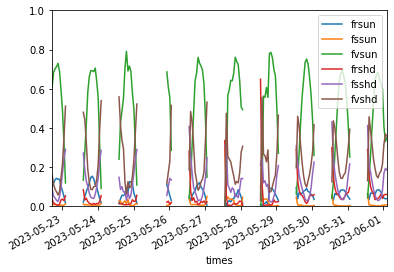

In [61]:
df.plot(x='times',y=['frsun','fssun','fvsun','frshd','fsshd','fvshd'],xlim=[start_dates_cook[6],stop_dates_cook[7]],ylim=[0,1])

In [ ]:
f_snw_sun
